In [1]:
import tensorflow as tf
import pandas as pd

# Read csv file, select input variables
data=pd.read_csv('WFR_PTINR_Sev_5days_bwt_ht_BSA_20200212.csv')
data_select=data[['sex','age','bwt','ht','PTINR_1','PTINR_2','PTINR_3','PTINR_4','WFR_1','WFR_2','WFR_3','WFR_4', 'BSA']]
print(data_select.shape)

# split 90% to training, 10% test
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data_select.values, data[['PTINR_5']].values, test_size=0.1, random_state=0)
print(X_train.shape, Y_train.shape)
print(X_test.shape,Y_test.shape)

# normalize output variable by max value
trainanswers=Y_train/max(Y_train)
testanswers=Y_test/max(Y_test)

(22314, 13)
(20082, 13) (20082, 1)
(2232, 13) (2232, 1)


In [4]:
# Minmax scaling of inputs
from sklearn.preprocessing import MinMaxScaler
cs = MinMaxScaler()
trainContinuous = cs.fit_transform(X_train)
testContinuous = cs.fit_transform(X_test)

In [5]:
trainContinuous=pd.DataFrame(trainContinuous, columns=['sex','age','bwt','ht','PTINR_1','PTINR_2','PTINR_3','PTINR_4','WFR_1','WFR_2','WFR_3','WFR_4', 'BSA'])
testContinuous=pd.DataFrame(testContinuous, columns=['sex','age','bwt','ht','PTINR_1','PTINR_2','PTINR_3','PTINR_4','WFR_1','WFR_2','WFR_3','WFR_4', 'BSA'])


In [6]:
# data1 is input to dense layer networks, data2 is input to LSTM networks
data1=trainContinuous[['sex','age','bwt', 'ht', 'BSA']]
data2=trainContinuous[['PTINR_1', 'PTINR_2', 'PTINR_3','PTINR_4','WFR_1','WFR_2','WFR_3','WFR_4']]

#convert to tensor and reshape
data1_tf=tf.convert_to_tensor(data1)
data2_tf=tf.convert_to_tensor(data2)
data2_tf=tf.reshape(data2_tf, shape=[20082,4,2])

data2_tf.shape

TensorShape([20082, 4, 2])

In [7]:
# convert outputs to tensors and reshape
trainanswers_tf=tf.convert_to_tensor(trainanswers)
trainanswers_tf=tf.reshape(trainanswers_tf,shape=[20082,1])
trainanswers_tf.shape

TensorShape([20082, 1])

In [8]:
# tensors of test data
data1=testContinuous[['sex','age','bwt', 'ht', 'BSA']]
data2=testContinuous[['PTINR_1', 'PTINR_2', 'PTINR_3','PTINR_4','WFR_1','WFR_2','WFR_3','WFR_4']]

testdata1_tf=tf.convert_to_tensor(data1)
testdata2_tf=tf.convert_to_tensor(data2)
testdata2_tf=tf.reshape(testdata2_tf, shape=[2232,4,2])

testdata2_tf.shape

TensorShape([2232, 4, 2])

In [9]:
testanswers_tf=tf.convert_to_tensor(testanswers)
testanswers_tf=tf.reshape(testanswers_tf,shape=[2232,1])
testanswers_tf.shape

TensorShape([2232, 1])

In [15]:
# inputA is input to dense layer networks, inputB is input to LSTM networks
# construct model
inputA = tf.keras.Input(batch_input_shape=(None,5))
inputB = tf.keras.Input(batch_input_shape=(None,4,2))
# the first branch operates on the first input
x=tf.keras.layers.Dense(units=5, activation='relu', name='denselayer1')(inputA)
x=tf.keras.layers.Dense(units=16, activation='relu',  name='denselayer2')(x)
x=tf.keras.layers.Dense(units=16, activation='relu', name='denselayer3')(x)
x=tf.keras.layers.Dense(units=16, activation='relu', name='denselayer4')(x)
x=tf.keras.Model(inputs=inputA, outputs=x)

# the second branch opreates on the second input
y=tf.keras.layers.LSTM(units=32, return_sequences=True, name='lstm_1')(inputB)
y=tf.keras.layers.LSTM(units=32, return_sequences=True, name='lstm_2')(y)
y=tf.keras.layers.LSTM(units=32, return_sequences=True, name='lstm_3')(y)
y=tf.keras.layers.LSTM(units=32, name='lstm_4')(y)
y=tf.keras.layers.Dense(units=32, name="denselayer_after_lstm_1")(y)
y =tf.keras.Model(inputs=inputB, outputs=y)

# combine the output of the two branches
combined = tf.keras.layers.concatenate([x.output, y.output])
# apply dense layers and then a regression prediction on the
# combined outputs
z = tf.keras.layers.Dense(48, activation="relu")(combined)
z = tf.keras.layers.Dense(32, activation="relu")(z)
z = tf.keras.layers.Dense(32, activation="relu")(z)
z = tf.keras.layers.Dense(1, activation='relu')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = tf.keras.Model(inputs=[x.input, y.input], outputs=z)

In [16]:
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 4, 2)]       0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 4, 32)        4480        input_6[0][0]                    
__________________________________________________________________________________________________
denselayer1 (Dense)             (None, 5)            30          input_5[0][0]                    
______________________________________________________________________________________

In [34]:
opt = tf.keras.optimizers.Adam(lr=1e-3, decay=0.0001)
model.compile(loss="mean_absolute_error", optimizer=opt)
# train the model
print("[INFO] training model...")
model.fit(x=[data1_tf, data2_tf], y=trainanswers_tf,validation_split=0.22,epochs=20, batch_size=128)
# make predictions on the testing data
preds = model.predict([testdata1_tf, testdata2_tf])

[INFO] training model...
Epoch 1/20
123/123 [==============================] - 3s 25ms/step - loss: 0.0401 - val_loss: 0.0425
Epoch 2/20
123/123 [==============================] - 1s 10ms/step - loss: 0.0373 - val_loss: 0.0362
Epoch 3/20
123/123 [==============================] - 1s 9ms/step - loss: 0.0374 - val_loss: 0.0366
Epoch 4/20
123/123 [==============================] - 1s 9ms/step - loss: 0.0365 - val_loss: 0.0353
Epoch 5/20
123/123 [==============================] - 1s 10ms/step - loss: 0.0365 - val_loss: 0.0348
Epoch 6/20
123/123 [==============================] - 1s 9ms/step - loss: 0.0353 - val_loss: 0.0344
Epoch 7/20
123/123 [==============================] - 1s 9ms/step - loss: 0.0361 - val_loss: 0.0341
Epoch 8/20
123/123 [==============================] - 1s 9ms/step - loss: 0.0350 - val_loss: 0.0339
Epoch 9/20
123/123 [==============================] - 1s 9ms/step - loss: 0.0340 - val_loss: 0.0357
Epoch 10/20
123/123 [==============================] - 1s 8ms/step - los

In [35]:
import numpy as np
loss=tf.keras.metrics.mean_absolute_error(
    testanswers_tf, preds
)

In [36]:
np.mean(loss)

0.04525489

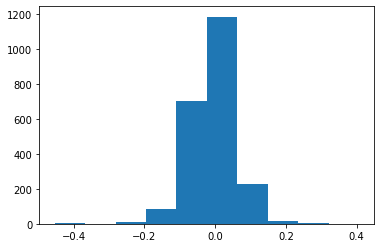

In [37]:
import matplotlib.pyplot as plt
outs=(preds-testanswers_tf).numpy()
plt.hist(outs)

plt.show()